In [1]:
from dataset_helpers import *
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import faiss
import time
import joblib
import csv

### Flicker-8k dataset

In [5]:
data = dataset(src_path=DATASET_PATH, feature_path=FEATURE_PATH)
data.get_file_name()
data.preprocess_dataset(entire_dataset=False)
# data.load_dataset()
print("Features: ", data.features)

In [3]:
query = "two people"
best_images = data.search_query(query, num_matches=10)
print("Length of features: ", len(data.features))
print("Best images: ", best_images)

Length of features:  8091
Best images:  [(0.2883, 8018), (0.2834, 5003), (0.2815, 844), (0.2798, 299), (0.2747, 7635), (0.2734, 125), (0.2727, 1396), (0.2712, 6869), (0.2703, 2844), (0.2698, 4334)]


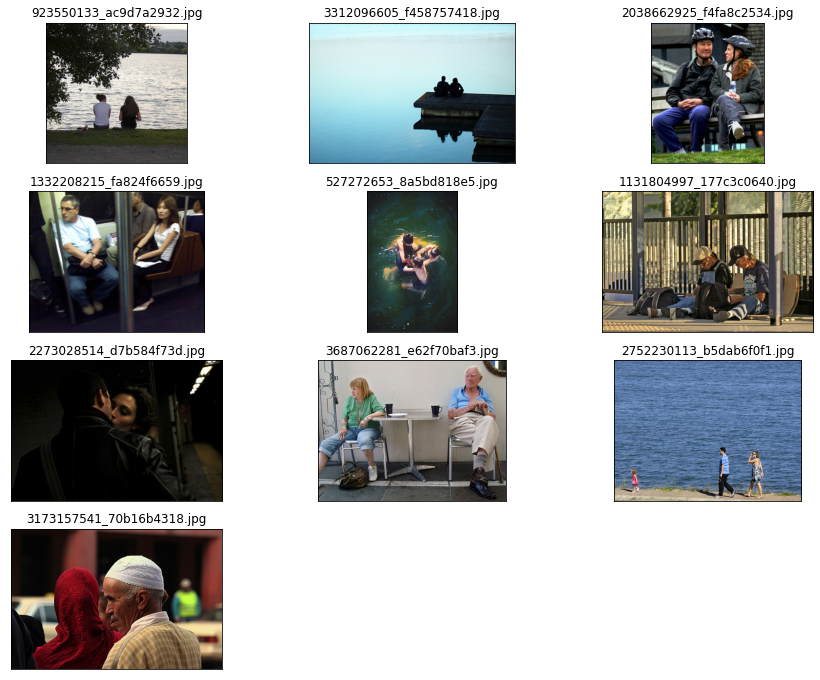

In [7]:
data.display_results(best_images)

### Using V3C1 sample dataset

In [2]:
DATASET_PATH

'/mnt/DEAKIN/VBS2022/keyframes'

In [3]:
# Whether you wanna generate new features
generate_features = True

print("Dataset name: ", DATASET_NAME)
clip = CLIPSearchEngine(src_path=DATASET_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)
# clip.dataset.get_file_name()

Dataset name:  V3C


In [4]:
clip.dataset.get_file_name()
clip.load_features()
print("Features: ", len(clip.features))

Loading all image names ...


0it [00:00, ?it/s]

Loading feature files ...
Features:  0


In [34]:
query = 'people standing on the beach'
# query = clip.dataset.image_names[1000]

Time:  0.5621833801269531
Length of features:  2508110


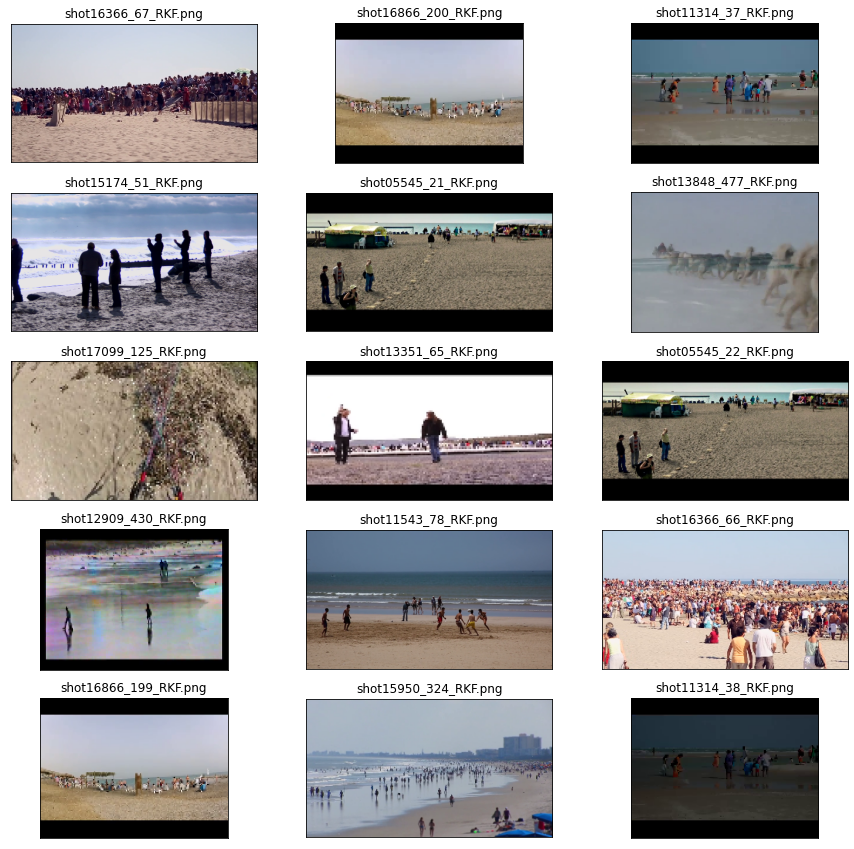

In [35]:
begin = time.time()
best_images = clip.search_query(query, num_matches=1000, ss_type='other')
# best_images = clip.search_query(query, num_matches=100, nlist=10, ss_type='faiss')
end = time.time()
print("Time: ", end - begin)
print("Length of features: ", len(clip.features))
display_results(best_images[:15])
# print("Best images: ", best_images)

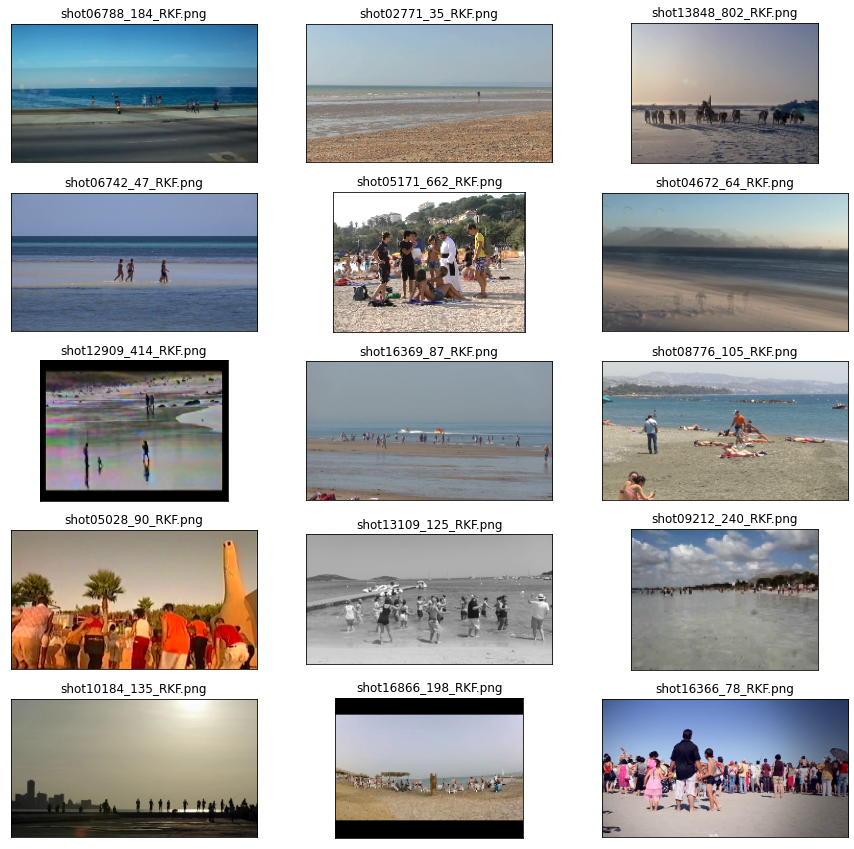

In [36]:
display_results(best_images[15:30])

In [37]:
is_image(clip.dataset.image_names[0])

True

In [57]:
# images = [Image.open(image_file) for image_file in image_batch]
images = [Image.open(clip.dataset.image_names[1000])]
filenames = [convert_to_concepts(clip.dataset.image_names[1000], dataset_name=clip.dataset_name)['filename']]
# Encode all images
images_encoded = torch.stack([clip.clip_model.encoder(image) for image in images]).to(clip.clip_model.device)
image_embeddings = clip.clip_model.encode_images(images_encoded)

In [58]:
similarity = image_embeddings @ feature_vector.T

In [59]:
similarity

array([[1.0001125]], dtype=float32)

In [62]:
temp = image_embeddings - feature_vector
np.sum(temp)

0.0014754534

#### Test faiss

Implement faiss algorithm for vector similarity search. After computing features, we will use faiss instead of Cosine similarity (the goal is to check whether it is faster or not).

In [10]:
clip.load_features()
print("Features: ", len(clip.features))

Loading feature files ...


100%|██████████| 156757/156757 [01:45<00:00, 1489.51it/s]


Features:  2508110


In [11]:
query = "snow mountain"

In [12]:
text_encoded = clip.clip_model.encode_text_query(query)
    
# Retrieve the description vector and the image vectors
text_features = text_encoded.cpu().numpy().astype('float32')


In [33]:
type(text_features), text_features.shape

(numpy.ndarray, (1, 512))

In [35]:
# dimension = features.shape[1]
# nlist = 100

In [70]:
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist, faiss.METRIC_L2)

In [71]:
print(index.is_trained)   # False
index.train(features)  # train on the database vectors
print(index.ntotal)   # 0
index.add(features)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)   # 200

False
0
True
467488


In [72]:
nprobe = 2  # find 2 most similar clusters
# n_query = 10  
k = 100  # return 3 nearest neighbours
np.random.seed(0)   
# query_vectors = np.random.random((n_query, dimension)).astype('float32')
distances, indices = index.search(text_features, k)

In [73]:
indices

array([[181879, 181922, 283271, 342935, 456196, 138014,  76985, 456237,
        456215, 456227, 260736, 138007, 455051, 266858, 181904, 181897,
        109372, 456083,  95765, 290913, 283334, 234701, 456208, 456044,
        456248, 262990, 128358, 162248, 345315, 203366, 460419, 457121,
        367236, 266854, 283141, 193924, 455946, 343026, 181881, 390192,
        455217, 128196, 456141, 328948, 322292, 240601,  64947, 283139,
        181903, 456148, 254827, 456149, 359846, 174215, 456199, 358590,
        337006, 342934,  58669, 254937, 151011, 174354, 436454,  73683,
        442620, 430710, 425296, 456144,  65468,  80575, 455183, 254828,
        329302, 273732, 248138,  12601, 455951, 456242, 140753, 260671,
        273785, 171841, 155733, 456295, 273745, 456146, 273746, 456289,
        181896, 174218, 456167, 363707,  80267, 390202, 416248, 440283,
        374945, 193628, 328959, 112403]])

In [74]:
temp = [clip.dataset.image_names[x] for x in indices[0]]

In [18]:
# TEST COSINE SIMILARITIES
similarities = list((text_features @ clip.features.T).squeeze(0))

# Sort the images by their similarity scores
indices = sorted(zip(similarities, range(clip.features.shape[0])), key=lambda x: x[0], reverse=True)
# result = indices

In [22]:
distance, result = zip(*indices)

#### Find similar images

In [52]:
query = clip.dataset.image_names[1000]

In [53]:
is_image(query)

True

In [54]:
img_query = convert_to_concepts(query, dataset_name=DATASET_NAME)['filename']
feature = clip.feature_dict[img_query]
feature_vec = np.expand_dims(feature, axis=0)
feature_vector = feature_vec.astype('float32')

In [55]:
similarities = (feature_vector @ clip.features.T).squeeze(0)
indices = similarities.argsort()[-50:][::-1]
best_matched_image_names = [clip.dataset.image_names[item] for item in indices]

result = [convert_to_concepts(item, dataset_name=clip.dataset_name) for item in best_matched_image_names]

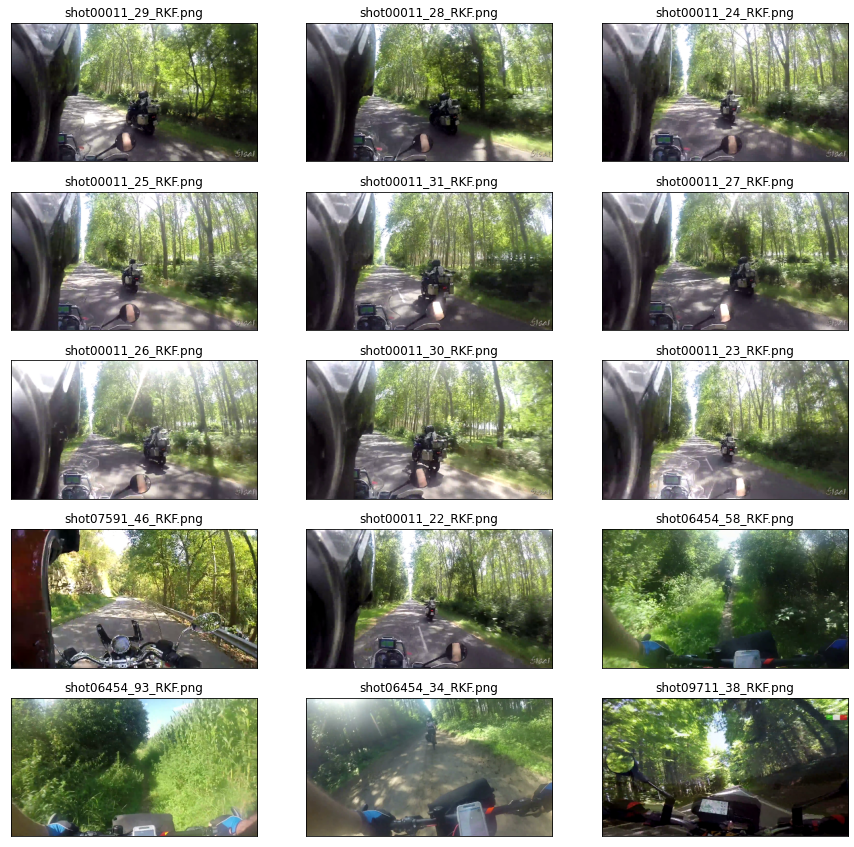

In [56]:
display_results(result[:15])

### Check Speed

In [10]:
query = "two man hugging"
feature_vector = clip.encode_input_query(query)

In [60]:
# feature_vector @ self.features.T).squeeze(0)

In [62]:
begin = time.time()
list_temp = (feature_vector @ clip.features.T).squeeze(0)
end = time.time()
print("Calculated time: ", end - begin)

Calculated time:  0.42061352729797363


In [64]:
type(list_temp)

numpy.ndarray

In [66]:
begin = time.time()
sorted_temp = np.sort((feature_vector @ clip.features.T).squeeze(0))
end = time.time()
print("Calculated time: ", end - begin)

Calculated time:  0.5150473117828369


In [72]:
begin = time.time()
similarities = (feature_vector @ clip.features.T).squeeze(0)
# Sort the images by their similarity scores
indices = sorted(zip(similarities, range(clip.features.shape[0])), key=lambda x: x[0], reverse=True)
best_matched_image_names = [clip.dataset.image_names[item[1]] for item in indices]
end = time.time()
print("Calculated time: ", end - begin)

Calculated time:  2.9666690826416016


In [92]:
similarities[:10]

array([0.21420684, 0.19794215, 0.2105448 , 0.2143192 , 0.17806299,
       0.1796506 , 0.18285522, 0.20718713, 0.1766547 , 0.20775013],
      dtype=float32)

In [91]:
similarities.shape

(2508110,)

In [78]:
a = np.array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
print(a)
# array([9, 4, 4, 3, 3, 9, 0, 4, 6, 0])
ind = np.argpartition(a, -4)[-4:]
ind

[9 4 4 3 3 9 0 4 6 0]


array([1, 5, 8, 0])

In [79]:
a[ind]

array([4, 9, 6, 9])

In [80]:
type(similarities)

numpy.ndarray

In [88]:
# temp = np.random.rand(2000000, 512)
begin = time.time()
indices = np.argpartition(similarities, -20)[-4:]
best_matched_image_names = [clip.dataset.image_names[item] for item in indices]
end = time.time()
print("Calculated time: ", end - begin)

Calculated time:  0.014495611190795898


In [89]:
list_temp

array([ 727380, 2484406, 1149058, 2320466])

In [90]:
best_matched_image_names

['/mnt/DEAKIN/VBS2022/keyframes/05030/shot05030_412_RKF.png',
 '/mnt/DEAKIN/VBS2022/keyframes/17053/shot17053_35_RKF.png',
 '/mnt/DEAKIN/VBS2022/keyframes/07885/shot07885_57_RKF.png',
 '/mnt/DEAKIN/VBS2022/keyframes/15872/shot15872_182_RKF.png']

### Resize keyframes

In [2]:
resized_path = osp.join(DATASET_MASTER_PATH, 'resized_keyframes')
original_path = osp.join(DATASET_MASTER_PATH, 'keyframes/extract/00001')

In [3]:
filename_list = os.listdir(original_path)
len(filename_list)

114

In [4]:
img_path = filename_list[0]
img_path = osp.join(original_path, img_path)

In [6]:
img_path.split('/')

['',
 'mnt',
 'SEAGATE',
 'root',
 'V3C1',
 'keyframes',
 'extract',
 '00001',
 'shot00001_44_RKF.png']

In [32]:
import cv2
def resize_image(img_path, scale_percent=50, rename=False, filename=None):
    src_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    scale_percent = scale_percent

    #calculate the 50 percent of original dimensions
    width = int(src_img.shape[1] * scale_percent / 100)
    height = int(src_img.shape[0] * scale_percent / 100)
    dsize = (width, height)

    # resize image
    output = cv2.resize(src_img, dsize)
    
    if rename:
        cv2.imwrite(filename, output)
        return
        
    return output



In [33]:
resize_image(img_path, 25, rename=True, filename='abc.png')

In [28]:
output = resize_image(filename, 25)

#### Checking with results

In [55]:
results = ['b00002410_21i6bq_20150319_162318e',
        'b00002411_21i6bq_20150319_162318e',
        'b00002412_21i6bq_20150319_162319e',
        'b00002413_21i6bq_20150319_162320e',
        'b00002414_21i6bq_20150319_162320e']

In [56]:
# result = results[0]
result = 'B00012817_21I6X0_20180524_041616E.JPG'
best_image = best_images[0]['filename']

In [57]:
len(best_images)

200

In [58]:
for result in results:
    for image in best_images:
        image_name = image['filename'].split('/')[-1].split('.')[0]
#         print(image_name)
        if image_name in result:
            print(image)

### Split keyframes to subfolders

In [2]:
import subprocess

In [3]:
# folder_name = 'test_folder'
# path = osp.join('/home/ntnhu/projects/VideoFall-VBS2022/results/', folder_name)
# if not osp.isdir(path):
#     os.mkdir(path)
# subprocess.call(f"mv /home/ntnhu/projects/VideoFall-VBS2022/results/xxx/* {path}", shell=True)


1

In [7]:
V3C2_path = '/mnt/SEAGATE/root/V3C2/keyframes/'
V3C2_videos = sort_list(os.listdir(V3C2_path))
V3C2_keyframes = sort_list(glob(osp.join(V3C2_path, '*/*.png')))

In [9]:
V3C2_videos[-2]

'17235'

In [4]:
keyframe_path = '/mnt/DEAKIN/VBS2022/resized_keyframes/*.png'
keyframes = sort_list(glob(keyframe_path))

In [21]:
keyframes[0].split('/')[-1][4:9]

'00001'

In [26]:
for kf in tqdm(keyframes[10000:100000]):
    video_name = kf.split('/')[-1][4:9]
    video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
    if not osp.isdir(video_path):
        os.mkdir(video_path)
#     print(kf)
    subprocess.call(f"mv {kf} {video_path}", shell=True)

100%|██████████| 90000/90000 [40:34<00:00, 36.97it/s]  


In [24]:
# max_len = 17235
# for idx in range(1, 5):
#     video_name = f'{idx:05d}'
#     video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
#     if not osp.isdir(video_path):
#         os.mkdir(video_path)
#     for kf in tqdm(keyframes[:1000]):
#         if f'shot{video_name}' in kf:
# #             print(kf)
#             subprocess.call(f"cp {kf} {video_path}", shell=True)
    

In [27]:
temp_path = '/mnt/DEAKIN/VBS2022/resized_keyframes/*.png'
temp = sort_list(glob(temp_path))

### Load and Save image names

In [4]:
# Whether you wanna generate new features
generate_features = True

print("Dataset name: ", DATASET_NAME)
clip = CLIPSearchEngine(src_path=DATASET_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)
clip.dataset.get_file_name()

Dataset name:  V3C
Loading all image names ...


In [5]:
len(clip.dataset.image_names)

2508110

In [8]:
image_name_path = '/mnt/DEAKIN/VBS2022/metadata'
filename = osp.join(image_name_path, 'image_names.joblib')
csv_filename = osp.join(image_name_path, 'image_names.csv')
# joblib.dump(clip.dataset.image_names, filename)
with open(csv_filename, 'w') as f:
    # create the csv writer
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(clip.dataset.image_names)

In [27]:
begin = time.time()
df = pd.read_csv(csv_filename, names=['filename'])
df.filename.to_list()
end = time.time()
len(data), end - begin

(2508110, 1.8340351581573486)

In [31]:
with open('abc.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f, delimiter=',')
    writer.writerow('ab, sd')